# Genomic Data Analysis using Python 🐍🧬
### Part 1. Genomic Data Preparation Pipeline        

Next-Gen Sequencing platforms such as Illumina platform, produce sequencing output in **FASTQ** format, with which we will be working here. FASTQ contains DNA sequences reads in the form series of strings with quality scores for every base in the sequence. To correctly allign short reads into the long read we will use quality features of FASTQ file to filter out low-quality reads. For this we're going to use a few command-line tools commonly used in bioinformatics for DNA reads preprocessing. In this notebook, we will: 
1. Explore qualities of the reads and their lengths 
2. Preprocess the data based on their quality
3. Perform pipeline operations using bcftools and GATK (Genome Analysis Toolkit) 
4. Visualise data from the reads using IGV tool


All the processes are executed using Docker, ensuring reproducibility of the analysis. <br >
Docker Image used:
spark-edugen-2.4.3-0.1.7-ga024cfc

In [ ]:
# Pulling and running Docker Image with Bash commands:
! sudo docker pull biodatageeks/ds-notebook:spark-edugen-2.4.3-0.1.7-ga024cfc

! sudo docker run --rm -it -p 1000:8888 -e HOME=/tmp/jovyan -e
DS_LAB_GCS_KEY=/tmp/secrets -e USER=jovyan biodatageeks/ds-notebook:spark-
edugen-2.4.3-0.1.7-ga024cfc jupyter-lab --ip='*' --NotebookApp.token='' --
NotebookApp.password=''

## 1. Exploratory data analysis
Let's examine how does a raw FASTQ file from patient's sequenced DNA look like: 

In [2]:
! cat ./son.fq | head -20

@H0164ALXX140820:6:1101:10003:71138/1
GATGCTCAAACTCCAGGTAGTAACCTCAGGTTGTATCATAGCTCCTTTAGGGTACCTCACTGTTTTTAATAAGCACATGGTAAGGATGATGACTTCTCGTCATCTGAACGTATAATATAACAAAAACCTAAGCTACCCAAAGATGAGGAGT
+
=>>=@==?>>=>>>?9<=>?>>9:>?8>=>9<>=:==-=28=58=.;+;?)466;>?1.8>67<+9;>>=>=>:6<5>>':=5'5<=)9*),=-*1,+'*3=,)9)7+)$,,+?>;,,35?.?,@?*6=?@*8A,3,,7>9=..*<7=.-;
@H0164ALXX140820:6:1101:10003:71138/2
ATTGTGCTTAACAATGCTGTTCTGATCATGTCGAGCCCTAGATCGACAGGAGTTATTCACTATCCAAGATTATCAGGGCATAGCAAGAGAAGTTGTAGCATACACAATGATGCGCATGTCCCCCAGACTCTTCGATATGCGCAAAGTCGCT
+
995+7))>:,,94=,=96=,+79)6=+.,)6,$,)3++<+=,>269*;*=>)8<+;34?:/:,+?.-*6;>>;?@6???########################################################################
@H0164ALXX140820:6:1101:10013:32619/1
CATCTATTTAGCTGAAAGTATTAGAATTTCCAACTCAGAATTAAATAATATGAGAGCCATAAGGATTCAAACTGAAATGTCCAAAGATTGATTTGGCTTTAGGTAAAGCTTGATCTAGGCTCTTAACATGTGTGGGTTTCTTTTCTCTAAT
+
=>:>A?>0=:?=?>;1>?==>=>?9>>==7>=><>=>>:7=6=<=>==>>>>=>,?><?9;;7:<>=>-=,<>=:81<>=4;-0:9=>;=<==*/:=?864?;72=7(=@>5=??@;>?:

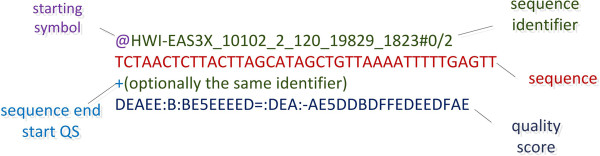

In [8]:
from IPython.display import Image
Image(filename='./fastq_explanation.png')

Above we can see the explanation of the FASTQ data format (by: Pavuoluos et al. 2013). <br > To access the quality and length of the reads we will use pysam- python package used for FASTQ files analysis as well as **SAM** and **BAM** files analysis. We will introduce these data formats later.  
Pysam allows for iteration over qualities of the reads saved in ASCII format of the FASTQ file and extraction of this qualities to dataframe. 

In [17]:
# Necessary imports:
import pysam
import pandas as pd

# Accessing quality of fastq files and placing it into an array:
fastqfile = "fastq/son.fq"
with pysam.FastxFile(fastqfile) as fh:
    df = DataFrame([[pysam.qualitystring_to_array(r.quality)] for r in fh])
    #print(df)

# Result is a DataFrame with one column and 54184 rows 

# Now, lets calculate length of arrays from all the rows: 
list_of_lengths = []
for read in df.iloc[:,0]:
    read_length = len(read)
    list_of_lengths.append(read_length)

print(list_of_lengths)

# Getting a mean length of read:
mean_length = np.mean(list_of_lengths)
#print(mean_length)



Mean length of our DNA read is 153 bases, which is a typical length for Illumina platform reads. 

In [ ]:
# Creating a new column named 'quals' and separating every element 
df.columns = ["quals"]
df2 = DataFrame(df.quals.values.tolist())
df2.median(axis=1)

## 2. Data preprocessing 
In the code above we explored just a few qualities of the reads. To ensure correct downstream analysis we should use dedicated command-line tool, like **FASTQC**. FASTQC assess reads molecular features and statistics  in more detail, also providing data visualisations and general assessment with GUI.

In [ ]:
! fastqc fastq/son.fq -o sandbox/fastqc_reports/

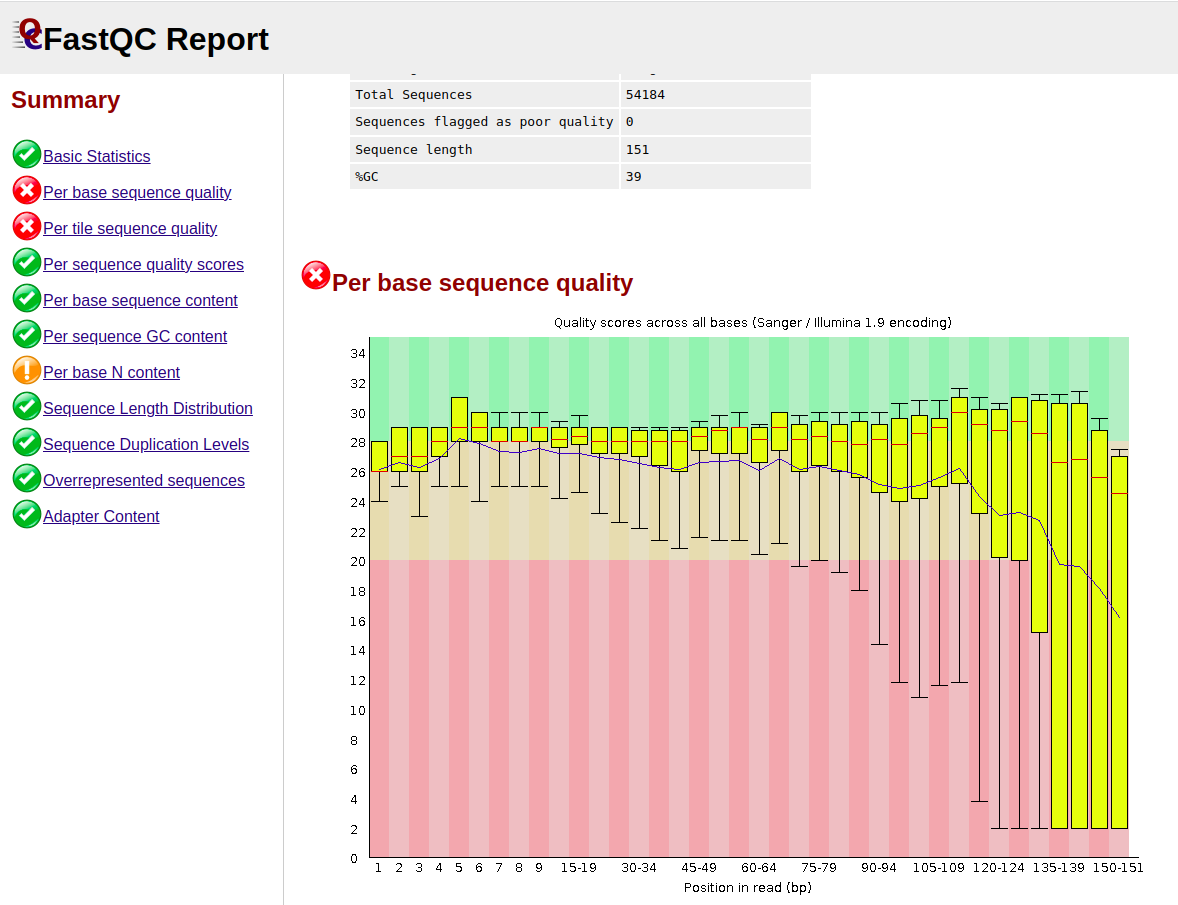

In [7]:
Image(filename='./fastqc- report .png')

In our data, **read quality seems to drop at the end of sequencing** (red colour means low quality of the read) which is a typical technical issue for Illumina platform. **Trimming reads of low-quality is essential for correct downstream analysis.** Low-quality reads may contain errors, which can lead to inaccurate results. Removing such reads ensures an increase of the  data reliability, allowing for more precise subsequent analyses. 

## 3. Pipeline operations

Reads from Illumina seqencers are typically short and do not span over the entire sequence of interest. In order to put the reads together into single read strand we need to use some computational power. We typically use BWA (Burrow's- Wheeler Algorythm) which serves to map the sequences (all these little elements) to a reference (which is entire sequenced genome of a man)- just like a puzzle. 
Output of this alignment is **SAM** (Sequence Alignment/ Map) file. It includes details like read sequences, alignment positions, CIGAR (Compact Idiosyncratic Gapped Alignment Report) strings representing insertions and deletions (when compared to reference genome) in a sequenced sample as well as quality scores.

Here we will use another command-line tool- bwa mem for processing FASTQ into SAM; then we will look into how does this format looks like:

In [22]:
# We use -p parameter for paired reads, which describes the format in which read was obtained 
#! bwa mem -p ref/ref.fasta fastq/son.fq > sandbox/son.sam
! cat ./son.txt | head -10 

@SQ	SN:20	LN:63025520
@PG	ID:bwa	PN:bwa	VN:0.7.17-r1188	CL:bwa mem -p ref/ref.fasta fastq/son.fq
H0164ALXX140820:6:1101:10003:71138	99	20	10093069	60	79M72S	=	10093356	311	GATGCTCAAACTCCAGGTAGTAACCTCAGGTTGTATCATAGCTCCTTTAGGGTACCTCACTGTTTTTAATAAGCACATGGTAAGGATGATGACTTCTCGTCATCTGAACGTATAATATAACAAAAACCTAAGCTACCCAAAGATGAGGAGT	=>>=@==?>>=>>>?9<=>?>>9:>?8>=>9<>=:==-=28=58=.;+;?)466;>?1.8>67<+9;>>=>=>:6<5>>':=5'5<=)9*),=-*1,+'*3=,)9)7+)$,,+?>;,,35?.?,@?*6=?@*8A,3,,7>9=..*<7=.-;	NM:i:1	MD:Z:47C31	MC:Z:63S24M64S	AS:i:74	XS:i:0
H0164ALXX140820:6:1101:10003:71138	147	20	10093356	60	63S24M64S	=	10093069	-311	AGCGACTTTGCGCATATCGAAGAGTCTGGGGGACATGCGCATCATTGTGTATGCTACAACTTCTCTTGCTATGCCCTGATAATCTTGGATAGTGAATAACTCCTGTCGATCTAGGGCTCGACATGATCAGAACAGCATTGTTAAGCACAAT	########################################################################???6@?;>>;6*-.?+,:/:?43;+<8)>=*;*962>,=+<++3),$,6),.+=6)97+,=69=,=49,,:>))7+599	NM:i:0	MD:Z:24	MC:Z:79M72S	AS:i:24	XS:i:0
H0164ALXX140820:6:1101:10013:32619	83	20	10139085	

Here is an explanation how to understand this data format (by https://www.samformat.info/sam-format-flag):

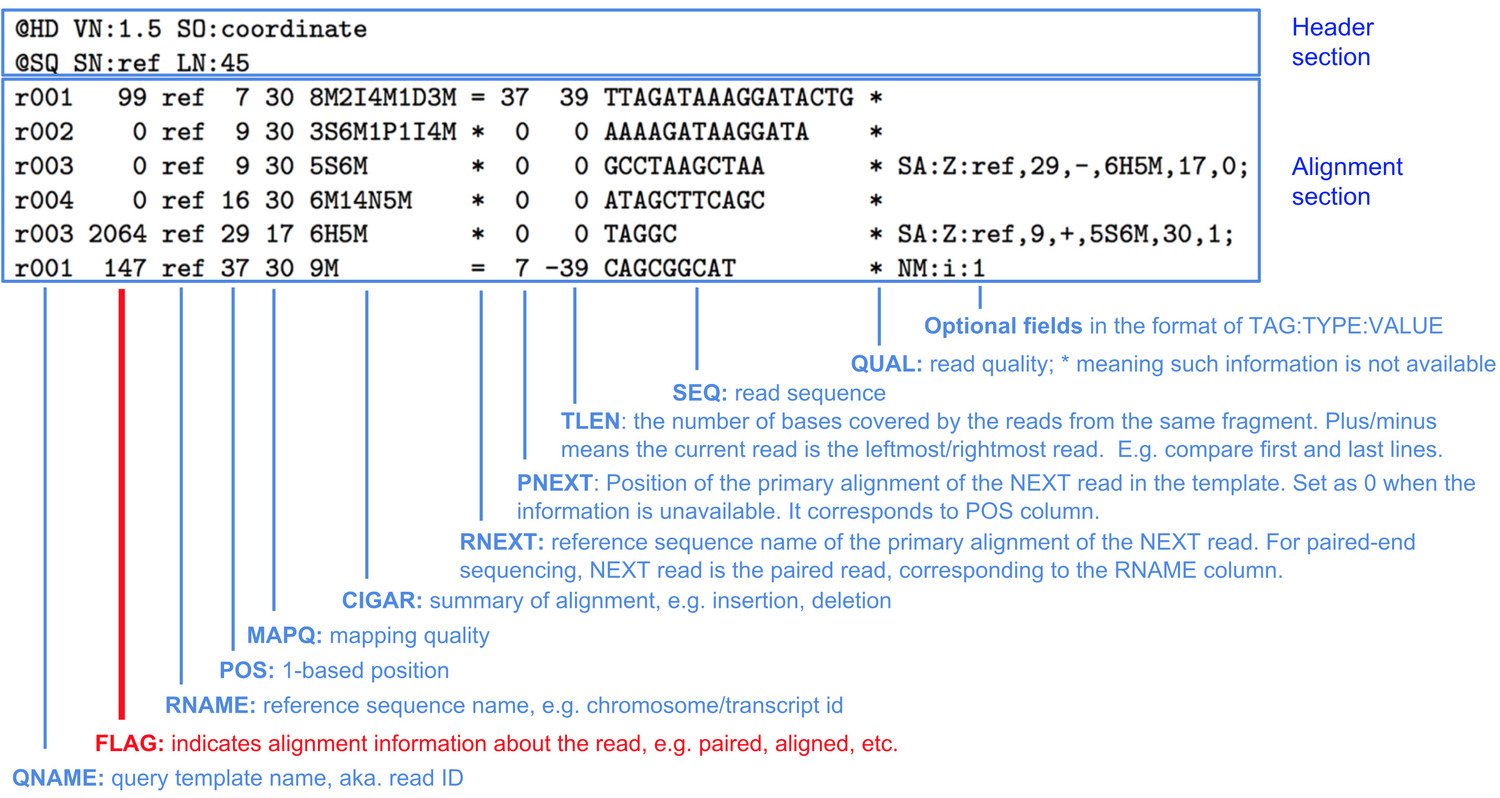

In [14]:
Image(filename='./sam_format.jpg')

Next, for efficient storage and faster data access we typically transform SAM file into **BAM** (Binary Alignment/Map) which is it's binary representation. For this we will use samtools:

In [12]:
! samtools view -bS -o son.bam son.sam

Next, we need to check how sucessfull mapping was: 

In [ ]:
! samtools flagstat sandbox/son.bam

This is our output:

54306 + 0 in total (QC-passed reads + QC-failed reads)
0 + 0 secondary
122 + 0 supplementary
0 + 0 duplicates
53994 + 0 mapped (99.43% : N/A)
54184 + 0 paired in sequencing
27092 + 0 read1
27092 + 0 read2
53282 + 0 properly paired (98.34% : N/A)
53560 + 0 with itself and mate mapped
312 + 0 singletons (0.58% : N/A)
0 + 0 with mate mapped to a different chr
0 + 0 with mate mapped to a different chr (mapQ>=5)


Alignment accuracy was achieved at a rate of 99.43%, signifying that the majority of sequencing reads were correctly mapped to the reference genome. Reads that did not map accurately to the reference are commonly referred to as **'variants'**. Variants play a significant role in genomics research due to their potential to carry genetic mutations responsible for genetic diseases.

Process of finding variants is called 'Variant Calling'. To explore variants further we should store them all  in a single file- **VCF**(Variant Call Format). For this we will need to use GATK tool with built-in **Haplotype Caller** (HC). HC is used to identify variations and mutations in DNA; it uses .bam file as input and produces .vcf output. It examines reads from DNA sequencing data and clusters them into haplotypes, which are groups of alleles on a single chromosome. This process helps detect single nucleotide polymorphisms (SNPs) and insertions/deletions (indels).

In [ ]:
# First three parameters establish reference genome and assembled input sequence and output format 
# - L flag also specifies specific locations of interest on chromosome. 
! gatk HaplotypeCaller \
    -R ${WORKSPACE}./ref/ref.fasta \
    -I ${WORKSPACE}./bam/son.bam \
    -O ${WORKSPACE}./sandbox/sonHC.vcf \
    -L 20:10,000,000-10,200,000 

Using GATK tools we acquired VCF file containing all the variants present in our sample. We will do some simple exploration on this file:

In [24]:
! cat ./sonHC.vt.vcf | head -100

##fileformat=VCFv4.2
##FILTER=<ID=PASS,Description="All filters passed">
##FILTER=<ID=LowQual,Description="Low quality">
##FORMAT=<ID=AD,Number=R,Type=Integer,Description="Allelic depths for the ref and alt alleles in the order listed">
##FORMAT=<ID=DP,Number=1,Type=Integer,Description="Approximate read depth (reads with MQ=255 or with bad mates are filtered)">
##FORMAT=<ID=GQ,Number=1,Type=Integer,Description="Genotype Quality">
##FORMAT=<ID=GT,Number=1,Type=String,Description="Genotype">
##FORMAT=<ID=PL,Number=G,Type=Integer,Description="Normalized, Phred-scaled likelihoods for genotypes as defined in the VCF specification">
##GATKCommandLine=<ID=HaplotypeCaller,CommandLine="HaplotypeCaller --output ./sandbox/sonHC.vcf --intervals 20:10,000,000-10,200,000 --input ./bam/son.bam --reference ./ref/ref.fasta --annotate-with-num-discovered-alleles false --heterozygosity 0.001 --indel-heterozygosity 1.25E-4 --heterozygosity-stdev 0.01 --standard-min-confidence-threshold-for-calling 30.0 --

Below a big header we can find our data, with every variation found on a chromosome indexed. Here is a picture describing this data format (by: https://davetang.github.io/learning_vcf_file/): 

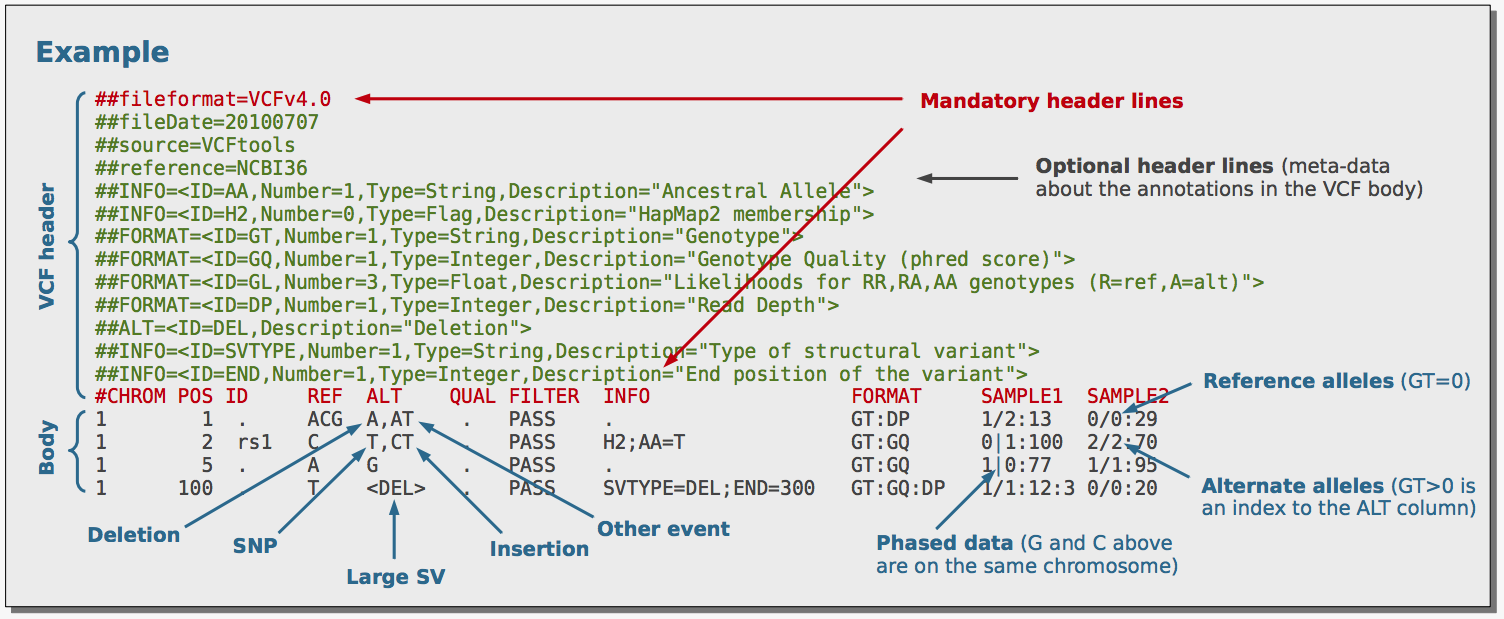

In [25]:
Image(filename='./vcf_explanation.png') 

In [ ]:
! bcftools view sandbox/sonHC.vcf | grep -v "^#" | wc -l

There are 421 variants. To further investigate VCF format we can check for **multiallelic variants** (mv). MV regards to the situation where more than 2 alleles are present. Typically there are 2 alleles for every gene in human body and presence of more than 2 may in some cases be indicative of the deviation from the norm. For this, we will use another tool, vt:

In [ ]:
# We use -f flag to specify filter condition which is '>= 3 alleles
! vt view -f "N_ALLELE>=3" sandbox/sonHC.vcf | wc -l

There are 6 MV-s. In order to asess if they could be linked with any disease, we're going to need VEP annotation to predict whether they are of pathogenic type (we will do this in part 2).

To further explore VCF file we can check how many of them are **heterogenic** and how many are **homogenic**, using another pipeline tool, called bcftools. 

In [ ]:
# with -i flag we will specify the filtering condition, then we will get rid of VCF headers with -H flag. 
! bcftools view -i 'GT="het"' sandbox/sonHC.vcf | bcftools view -H | wc -l
! bcftools view -i 'GT="hom"' sandbox/sonHC.vcf | bcftools view -H | wc -l

There are 191 heterozygotic and 230 homozygotic variants. In the context of variant analysis, understanding the zygosity of identified variants is of great importance. Zygosity refers to the genetic state of an individual regarding a specific variant, indicating whether the variant is present in one or both copies of the allele. Assessing zygosity is a important step in variant interpretation. Some variants exhibit zygosity-dependent effects on health, where they may be pathogenic in one zygosity state and benign in another.

# 4. BAM and VCF Data Visualisation 



BAM data as well as VCF data can be visualised on the reference genome using **IGV** (Integrative Genomics Viewer- https://igv.org/) which serves important objectives:

1. Quality Control: IGV aids in the assessment of data quality by visualizing read alignment, coverage depth, and the overall integrity of sequencing data. Deviations and anomalies can be readily identified.

2. Variant Exploration: Researchers can use IGV to inspect variant calls and confirm the presence of genetic variations, including single nucleotide variants (SNVs), insertions, deletions, and structural variants.




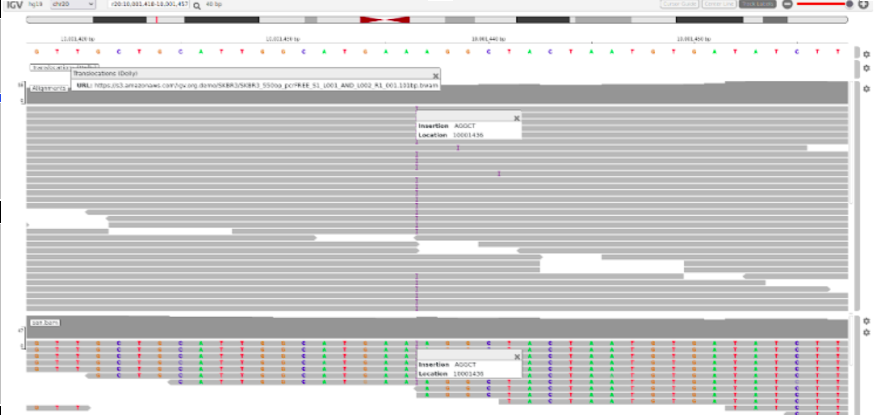

In [26]:
Image(filename='./igv_tracks.png') 

In IGV, reads are represented as grey arrows, with direction specifing direction of the read. Variants, including SNP (Single Nucleotide Polymorphism) and INDEL (Insertion, Deletion) are outlined with coloured letter- for the former and gaps without reads- for the latter. Below the reads we can also find histogram picturing distribution of the reads from BAM file in every position. Besides BAM, in IGV, also VCF files can be uploaded for better visualisation of the locations of interest.<br > Specific locations of interest on the chromosome can be established upon analysing VCF file and VEP annotation. 

In **Part 2** we will further work with VCF, annotating it to the public gene databases to search for potentially harmful variants. 